In [ ]:
# Libraries: Standard ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library for boxplots
import seaborn as sns

# Library scikit-learn 
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator

# K-means function
from sklearn.cluster import KMeans

# Functions for silhouette
from sklearn.metrics import silhouette_samples, silhouette_score

# Functions for hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist

In [ ]:
data_spotify=pd.read_csv("playlist_dataset.csv", sep=",")
data_spotify_copy = data_spotify.copy() # on travaille avec une copie 

In [ ]:
data_spotify_copy.shape # taille du df

(2300, 23)

In [ ]:
data_spotify_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playlist_url       2300 non-null   object 
 1   year               2300 non-null   int64  
 2   track_id           2300 non-null   object 
 3   track_name         2300 non-null   object 
 4   track_popularity   2300 non-null   int64  
 5   album              2300 non-null   object 
 6   artist_id          2300 non-null   object 
 7   artist_name        2300 non-null   object 
 8   artist_genres      2300 non-null   object 
 9   artist_popularity  2300 non-null   int64  
 10  danceability       2299 non-null   float64
 11  energy             2299 non-null   float64
 12  key                2299 non-null   float64
 13  loudness           2299 non-null   float64
 14  mode               2299 non-null   float64
 15  speechiness        2299 non-null   float64
 16  acousticness       2299 

In [ ]:
data_spotify_copy.duplicated().any() # pour voir s'il y a des lignes en double

np.False_

In [ ]:
data_spotify_copy.isnull().sum() # pour voir le nbr de NaN dans chaque colonnne 
data_spotify_copy[data_spotify_copy.isnull().any(axis=1)] # pour voir les lignes avec des NaN

# on peut juste la supprimer
data_spotify_copy.dropna(inplace=True)  # on a maintenant 2299 lignes

In [ ]:
data_spotify_copy.nunique() # pour voir le nbr de valeurs uniques dans chaque colonne 

playlist_url           23
year                   23
track_id             2201
track_name           2120
track_popularity       71
album                1663
artist_id             891
artist_name           891
artist_genres         698
artist_popularity      62
danceability          585
energy                641
key                    12
loudness             1897
mode                    2
speechiness           860
acousticness         1322
instrumentalness      841
liveness              807
valence               827
tempo                2074
duration_ms          2033
time_signature          4
dtype: int64

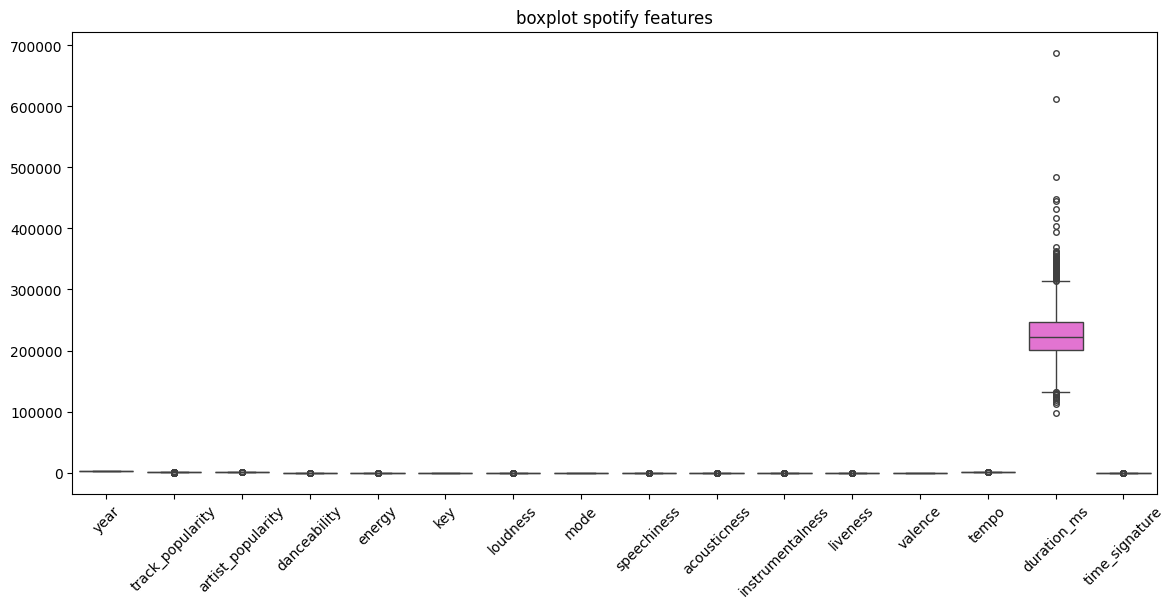

In [ ]:
plt.figure(figsize=(14,6))
plt.title('boxplot spotify features')
data_box=sns.boxplot(data=data_spotify_copy,fliersize=4)  
plt.xticks(rotation=45)
plt.show()

# on voit clairement que la colonne duration_ms a des valeurs bien plus grandes que les autres(logique)
# prblm => les algo vont donner bcp plus de poids à cette colonne et invisibilise les autres features

Variances avant standardisation :
 year                 4.401696e+01
track_popularity     1.511436e+02
artist_popularity    1.483647e+02
danceability         1.991956e-02
energy               2.717159e-02
key                  1.316597e+01
loudness             4.329950e+00
mode                 2.403982e-01
speechiness          8.546066e-03
acousticness         4.155235e-02
instrumentalness     7.054317e-03
liveness             1.732375e-02
valence              5.190221e-02
tempo                7.627390e+02
duration_ms          1.769353e+09
time_signature       4.798469e-02
dtype: float64
Valeur moyenne de la variance 
 110584636.28505532


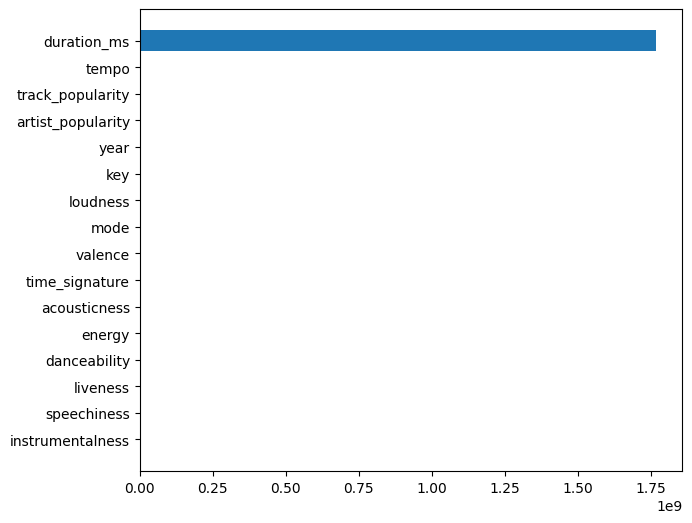

In [ ]:
numeric_df = data_spotify_copy.select_dtypes(include=[float, int]) # on garde que les colonnes avec des valeurs numériques pour le calcul de la var
variances = numeric_df.var()
print("Variances avant standardisation :\n" , variances)

mean_var = numeric_df.var().mean() 
print('Valeur moyenne de la variance \n', mean_var)

# visualisation
plt.figure(figsize=(7,6))
plt.barh(numeric_df.var().sort_values().index, numeric_df.var().sort_values().values) # visualisation de la variance 
plt.show()

# la moyenne calculer est fortement influencée par la duration_ms, la variance est tellement élevée qu'elle invisibilise le reste des valeurs

In [ ]:
skew_variables = numeric_df.skew().to_frame().rename(columns={0 :'skew'})  # calcul du skew de chaque colonne de numeric_df
print(skew_variables.sort_values('skew', ascending=False))

                       skew
instrumentalness   7.946269
liveness           1.997885
speechiness        1.920069
acousticness       1.823303
duration_ms        1.626116
tempo              0.553702
key                0.023334
year              -0.000866
valence           -0.076419
danceability      -0.398012
mode              -0.402227
artist_popularity -0.409799
energy            -0.630005
loudness          -1.247591
track_popularity  -2.341099
time_signature    -5.431689


In [ ]:
highly_skewed = skew_variables[skew_variables['skew'] > 0.75] # si la varaiable est asymétrique à droite (très grandes valeurs)
lis = highly_skewed.index.to_list() # on réalise une liste des valeurs à transformer

print(lis) # on peut regarder ce qu'il y a dans la liste

for col in lis:
  numeric_df[col] = np.log1p(numeric_df[col]) # on transforme chaque colonne avec np.log1p pour réduire l'effet des outliers
  
# Cela permet de reduire l'asymétrie à droite et donc logiquement de rendre les données plus symmétrique 

['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']


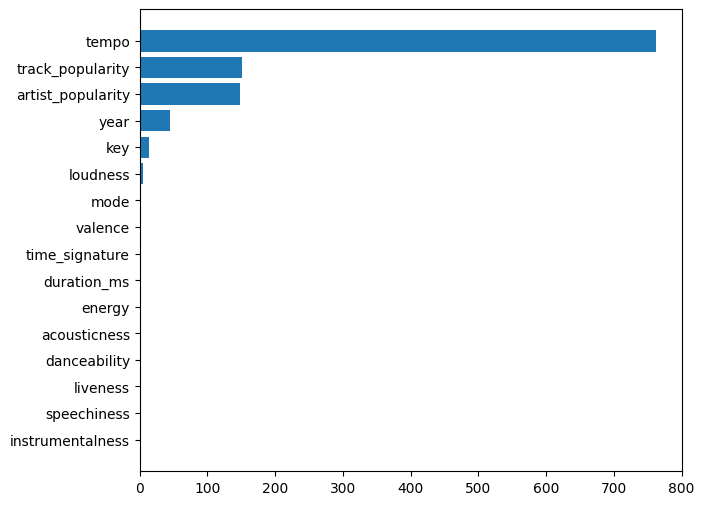

Variances :
 year                  44.016962
track_popularity     151.143596
artist_popularity    148.364737
danceability           0.019920
energy                 0.027172
key                   13.165967
loudness               4.329950
mode                   0.240398
speechiness            0.006169
acousticness           0.024440
instrumentalness       0.004141
liveness               0.010560
valence                0.051902
tempo                762.738973
duration_ms            0.031542
time_signature         0.047985
dtype: float64


In [ ]:
# visualisation
plt.figure(figsize=(7,6))
plt.barh(numeric_df.var().sort_values().index, numeric_df.var().sort_values().values) # visualisation de la variance 
plt.show()

variances_2 = numeric_df.var()
print("Variances :\n" , variances_2)

# Variance faible => variables peu informatives, variance élevée => variables discriminantes


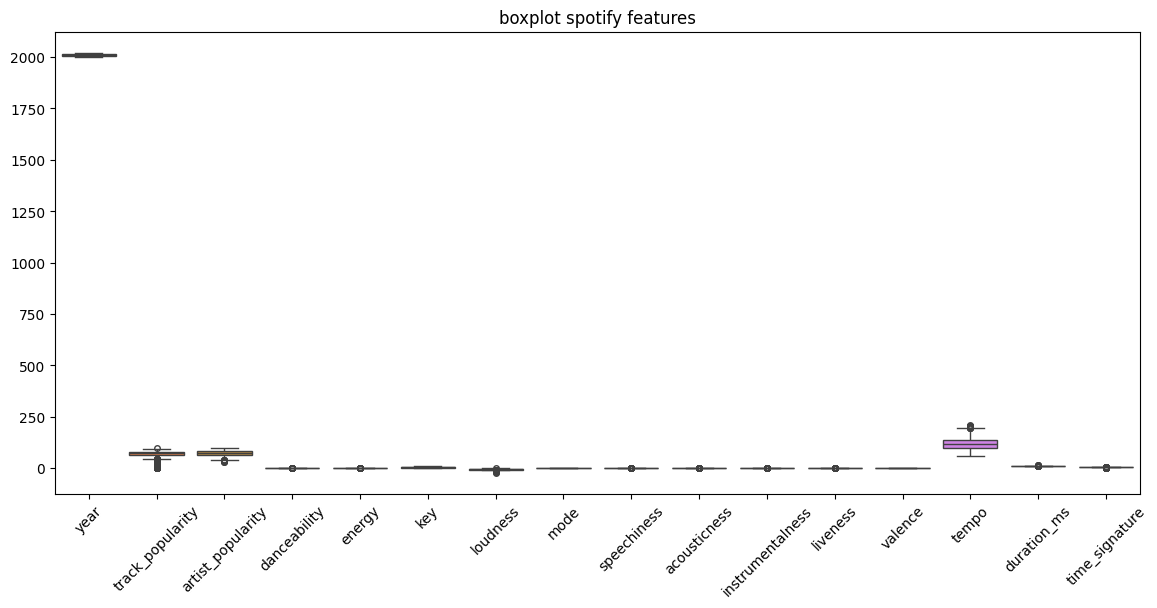

In [ ]:
# visualisation
plt.figure(figsize=(14,6))
plt.title('boxplot spotify features')
data_box=sns.boxplot(data=numeric_df,fliersize=4)  
plt.xticks(rotation=45)
plt.show()

In [ ]:
# pour étudier la corrélation
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) #calcul du Variance Inflation Factor pour chaque variable
                   for i in range(numeric_df.shape[1])]
print(vif_data)

# Chaque valeur correspond à une mesure de colinéarité entre une variable et toutes les autres du jeu de données
# Pour VIF > 10 => on a une grosse multicolinarité sérieuse à traiter (rétirer ou combiner)
# la variable va être fortement prédite par les autres et donc son coeff est instable

              Feature          VIF
0                year  4743.757554
1    track_popularity    39.001634
2   artist_popularity    43.789712
3        danceability    33.229983
4              energy    50.263328
5                 key     3.206147
6            loudness    17.731128
7                mode     2.616238
8         speechiness     2.490479
9        acousticness     2.508465
10   instrumentalness     1.087604
11           liveness     3.375317
12            valence    10.088993
13              tempo    21.699637
14        duration_ms  4100.250945
15     time_signature   342.969919


<function matplotlib.pyplot.show(close=None, block=None)>

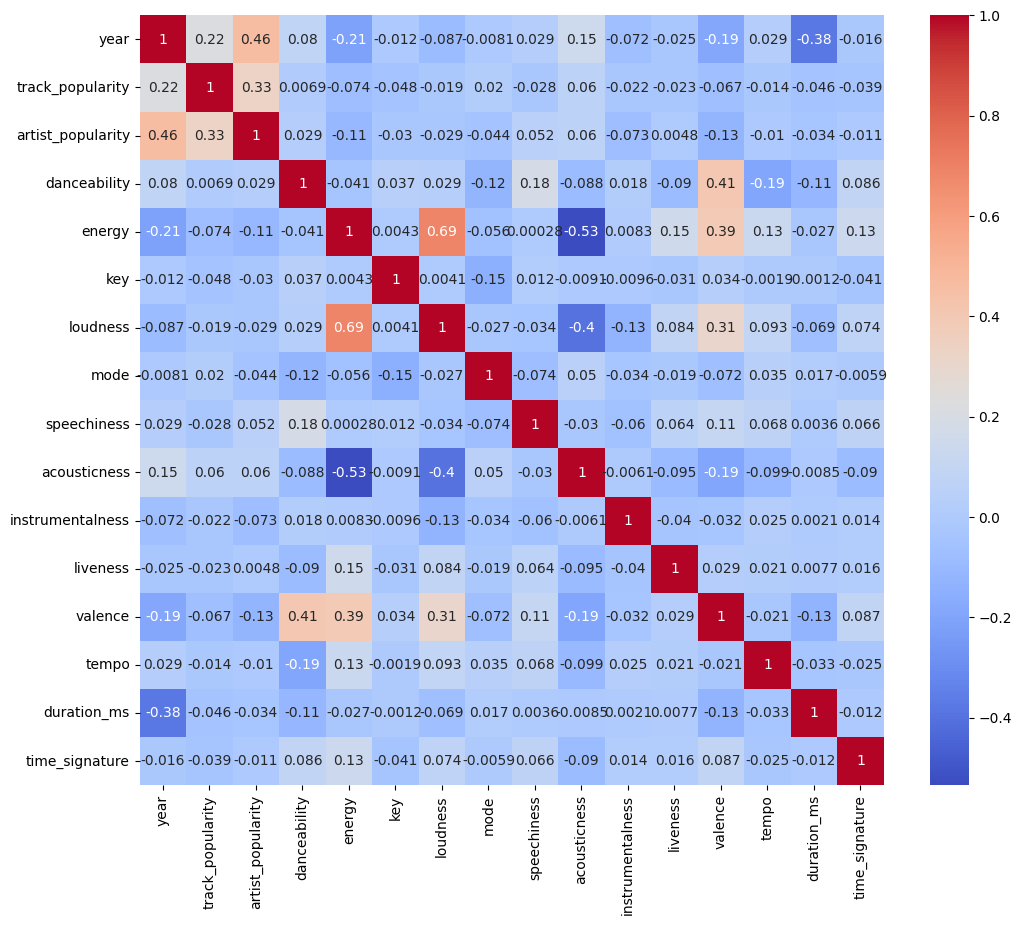

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=True) # les variables ayant coefficient > 0.8 portent souvent la même info
plt.show

# en particulier loudness et energy (coeff=0.69), valence et loudness (0,31), valence et danceability (0.41), valence et energy (0.39), artist popularity et year (0.46)
# loudness, energy et valence rende compte à peu près toutes de "à quel point un morceau est intense et énergique".

In [ ]:
#Calcul du PCA

# Etape de standardisation
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numeric_df)

pca=PCA()
spotify_pca=pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_ # pour chaque PC, le pourcentage de variance totale qu'elle explique
cumulative_variance = np.cumsum(explained_variance) # variance totale exprimée par les première k-composantes

print(explained_variance)
print(np.linalg.matrix_rank(data_scaled)) # 16 PC au total

# Rappel: PC = combinaison linéaire des variables qui contribuent le plus (capturent chacun une dimension)

[0.15899349 0.11022387 0.09396384 0.07082962 0.06949586 0.06741224
 0.0644593  0.06023695 0.05837434 0.05113926 0.04711899 0.04185914
 0.03926432 0.02944738 0.02241169 0.01476972]
16


In [ ]:
# On peut visualiser le poids de chaque variable dans chacune des PC
loadings = pd.DataFrame(pca.components_.T, 
                        index=numeric_df.columns, 
                        columns=[f'PC{i+1}' for i in range(len(pca.components_))])
print(loadings)

                        PC1       PC2       PC3       PC4       PC5       PC6  \
year              -0.263457  0.523756 -0.134896  0.007027 -0.140459  0.158768   
track_popularity  -0.151550  0.337398 -0.203593 -0.066922  0.101301 -0.379151   
artist_popularity -0.200206  0.470764 -0.207028  0.108184  0.191956 -0.221468   
danceability       0.101845  0.303495  0.574663 -0.142653  0.047474 -0.048014   
energy             0.532627  0.080958 -0.219227  0.001100 -0.053422 -0.073724   
key                0.027314  0.001034  0.170525  0.595043 -0.304587 -0.155377   
loudness           0.462544  0.176697 -0.237336 -0.038630 -0.071097 -0.151552   
mode              -0.065886 -0.126350 -0.236364 -0.569193  0.085027  0.158049   
speechiness        0.044832  0.158664  0.234904  0.273378  0.499425  0.437665   
acousticness      -0.418122 -0.083420  0.147274 -0.049658 -0.004434  0.074627   
instrumentalness  -0.017442 -0.140325  0.097933 -0.050825 -0.347405  0.110996   
liveness           0.114561 

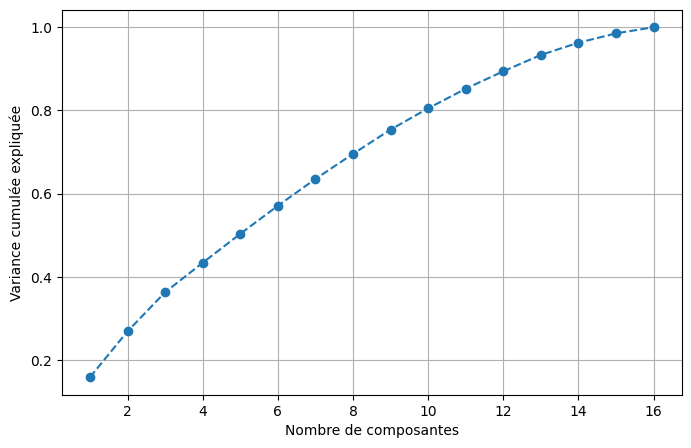

In [ ]:
# Visualisation de la variance cumulée
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance cumulée expliquée")
plt.grid(True)
plt.show()

[2.54500287 1.76434936 1.50407568 1.1337671  1.1124176  1.07906515
 1.03179761 0.9642106  0.93439584 0.81858422 0.75423188 0.67003769
 0.62850242 0.47136314 0.35874314 0.23641828]


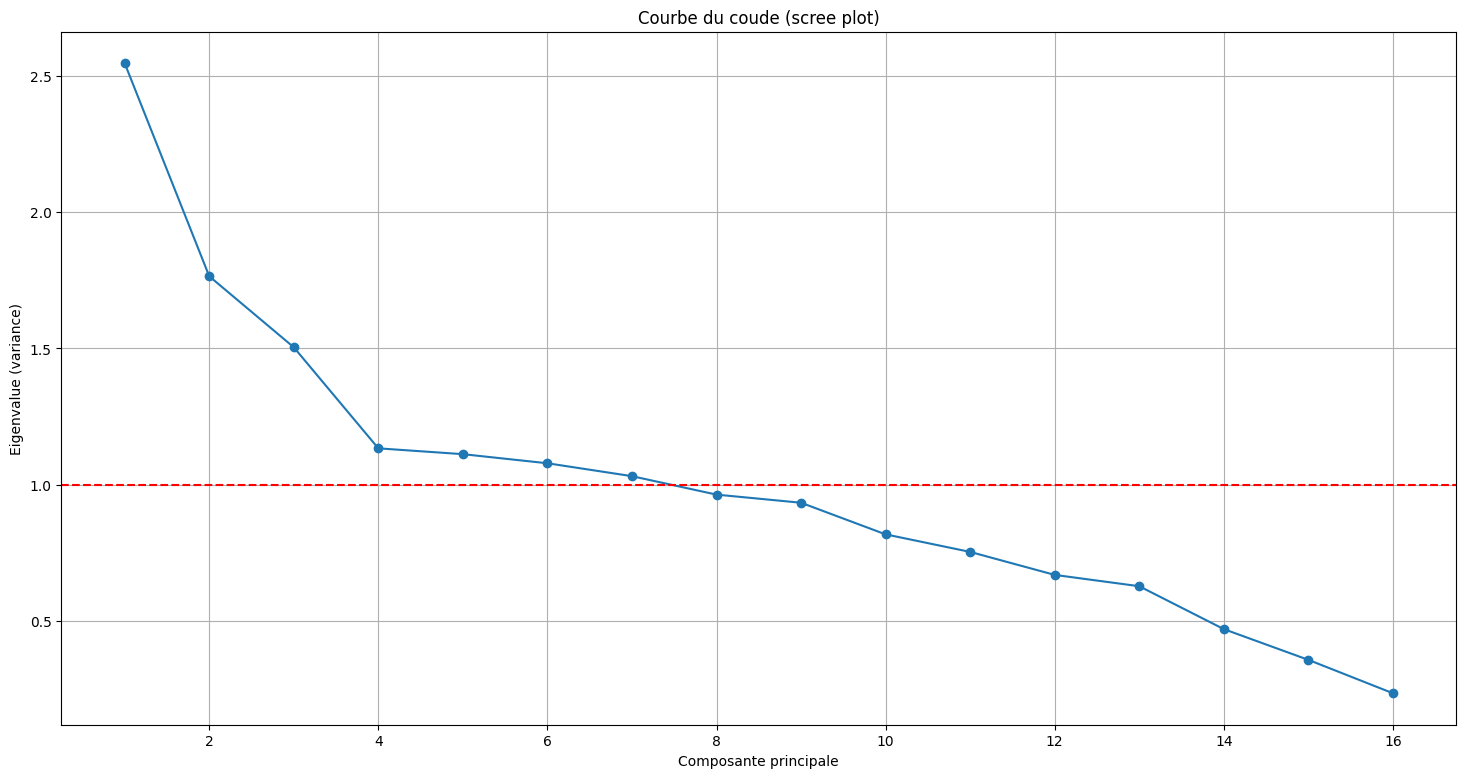

In [ ]:
# On peut aussi récupérer la variance brut de chaque composante (ev)
eigenvalues = pca.explained_variance_  # valeurs propres
mean_ev=np.mean(eigenvalues) # valeur moyenne
print(eigenvalues)

plt.figure(figsize=(18,9))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='-')

plt.axhline(y=mean_ev, color='red', linestyle='--', label=f'Moyenne EV = {mean_ev:.2f}')
plt.xlabel("Composante principale")
plt.ylabel("Eigenvalue (variance)")
plt.title("Courbe du coude (scree plot)")
plt.grid(True)
plt.show()

In [ ]:
knee = KneeLocator(range(1, len(eigenvalues)+1), eigenvalues, curve='convex', direction='decreasing')
print("Composante au coude :", knee.knee)

# la composante du coude est 4 => cela veut dire que les 4 première composantes capturent la majorité de la variance du set

Composante au coude : 4


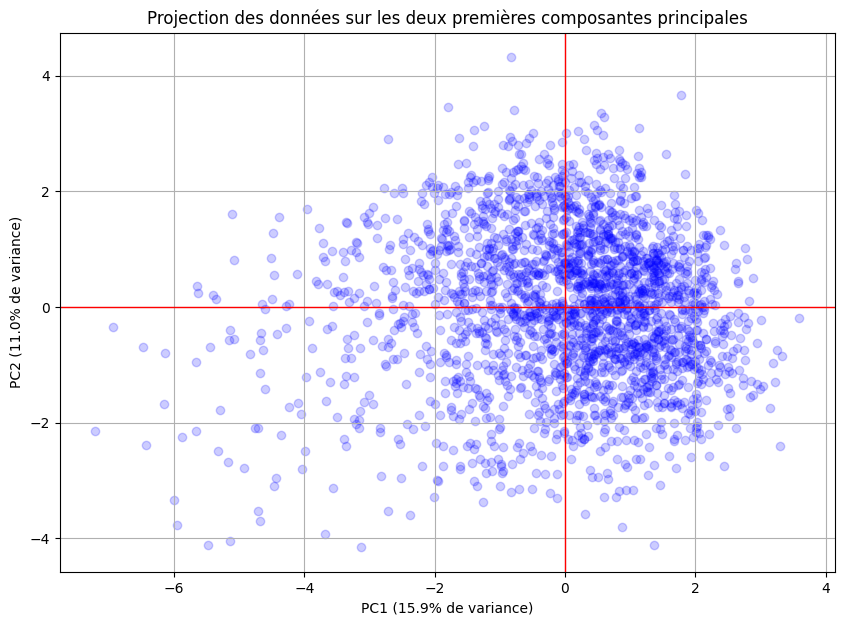

In [ ]:
# Visualisation des 2 premières PC
spotify_pca_2d = spotify_pca[:, :2]  # PC1 et PC2

plt.figure(figsize=(10,7))
plt.scatter(spotify_pca_2d[:,0], spotify_pca_2d[:,1], alpha=0.2, color='blue')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% de variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% de variance)")
plt.axhline(0, color='red', lw=1)
plt.axvline(0, color='red', lw=1)
plt.title("Projection des données sur les deux premières composantes principales")
plt.grid(True)
plt.show()

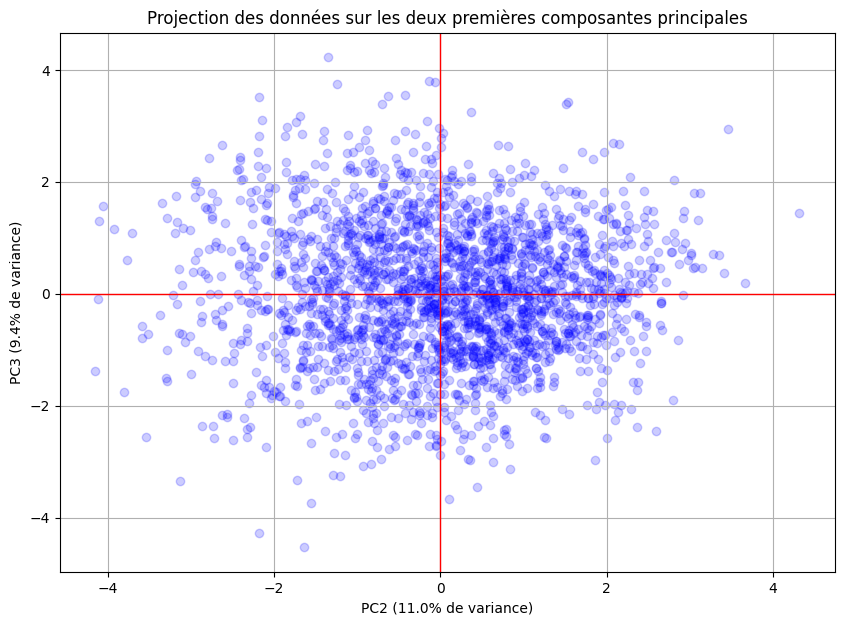

In [ ]:
# Visualisation de PC2 et PC3
spotify_pca_3d = spotify_pca[:, 1:3]  # PC2 et PC3

plt.figure(figsize=(10,7))
plt.scatter(spotify_pca_3d[:,0], spotify_pca_3d[:,1], alpha=0.2, color='blue')

plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% de variance)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% de variance)")
plt.axhline(0, color='red', lw=1)
plt.axvline(0, color='red', lw=1)
plt.title("Projection des données sur les deux premières composantes principales")
plt.grid(True)
plt.show()

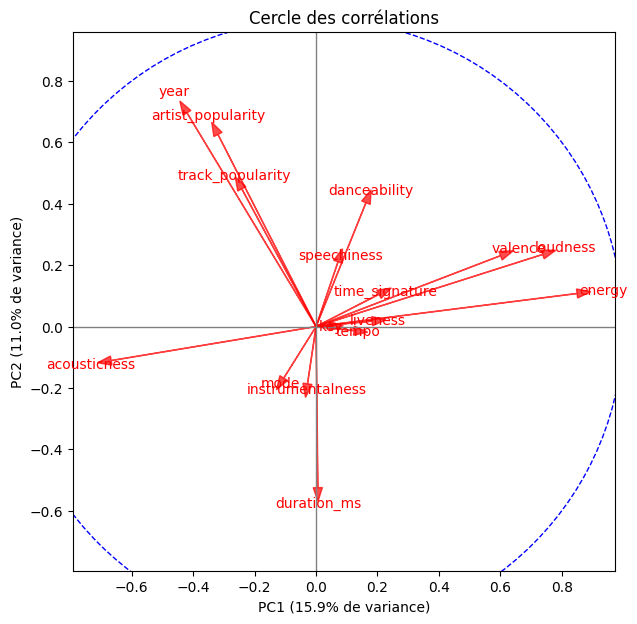

In [ ]:
loadings2 = pca.components_.T * np.sqrt(pca.explained_variance_)

data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_df.columns)

plt.figure(figsize=(7,7))
for i, var in enumerate(data_scaled_df.columns):
    plt.arrow(0, 0, loadings2[i,0], loadings2[i,1],
              color='r', alpha=0.7, head_width=0.03)
    plt.text(loadings2[i,0]*1.1, loadings2[i,1]*1.1, var, color='r', ha='center', va='center')

# Cercle unité
circle = plt.Circle((0,0), 1, color='blue', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% de variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% de variance)")
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title("Cercle des corrélations")
plt.axis('equal')
plt.show()

# Axe 1 => en lien avec "à quel point un morceau est intense et énergique" (à droite valence, energy et loudness et à gauche acousticness)
# Axe 2 => en lien avec la popularité d'un morceau (en haut popularité en bas durée du morceau)

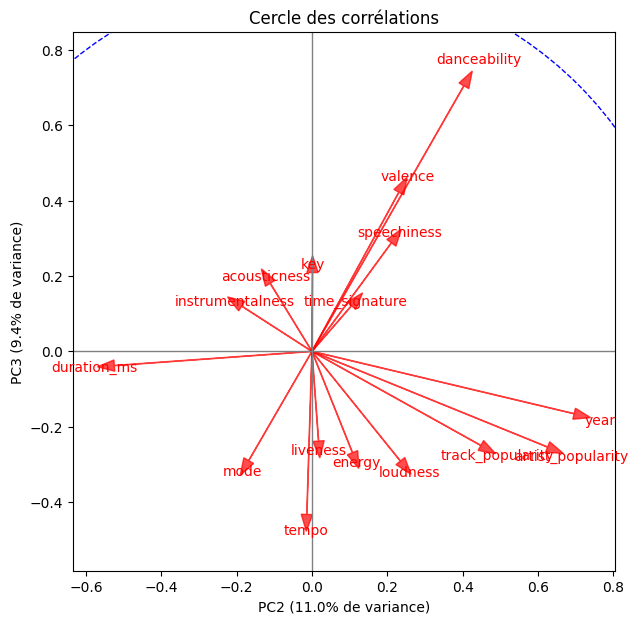

In [ ]:
loadings2 = pca.components_.T * np.sqrt(pca.explained_variance_)

data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_df.columns)

plt.figure(figsize=(7,7))
for i, var in enumerate(data_scaled_df.columns):
    plt.arrow(0, 0, loadings2[i,1], loadings2[i,2],
              color='r', alpha=0.7, head_width=0.03)
    plt.text(loadings2[i,1]*1.1, loadings2[i,2]*1.1, var, color='r', ha='center', va='center')

# Cercle unité
circle = plt.Circle((0,0), 1, color='blue', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% de variance)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% de variance)")
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title("Cercle des corrélations")
plt.axis('equal')
plt.show()

# Axe 3 => met en opposition key, danceability et liveness, tempo
# semble aussi opposer energy et acousticness

n_clusters = 2, silhouette_score = 0.122
n_clusters = 3, silhouette_score = 0.081
n_clusters = 4, silhouette_score = 0.089
n_clusters = 5, silhouette_score = 0.086
n_clusters = 6, silhouette_score = 0.090
n_clusters = 7, silhouette_score = 0.088
n_clusters = 8, silhouette_score = 0.088
n_clusters = 9, silhouette_score = 0.085
n_clusters = 10, silhouette_score = 0.088
n_clusters = 11, silhouette_score = 0.089
n_clusters = 12, silhouette_score = 0.090
n_clusters = 13, silhouette_score = 0.087
n_clusters = 14, silhouette_score = 0.083
n_clusters = 15, silhouette_score = 0.087
n_clusters = 16, silhouette_score = 0.081
n_clusters = 17, silhouette_score = 0.082
n_clusters = 18, silhouette_score = 0.082
n_clusters = 19, silhouette_score = 0.083


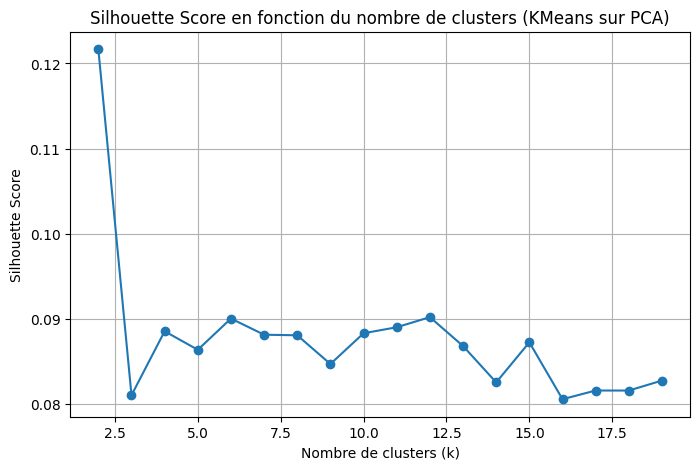

In [ ]:
#Clustering 

range_n_clusters = range(2,20)
silhouette_avgs = []

for n in range_n_clusters:
    kmeans_spotify = KMeans(n_clusters=n, n_init=10).fit(spotify_pca) # Clustering avec n clusters
    cluster_labels = kmeans_spotify.labels_ # Extraction des labels
    silhouette_avg = silhouette_score(spotify_pca, cluster_labels) # Silhouette score
   
    silhouette_avgs.append(silhouette_avg)
    print(f"n_clusters = {n}, silhouette_score = {silhouette_avg:.3f}")

plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, silhouette_avgs, marker='o')
plt.title("Silhouette Score en fonction du nombre de clusters (KMeans sur PCA)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Silhouette score est plutôt mauvais ( inférieur à 0.25)

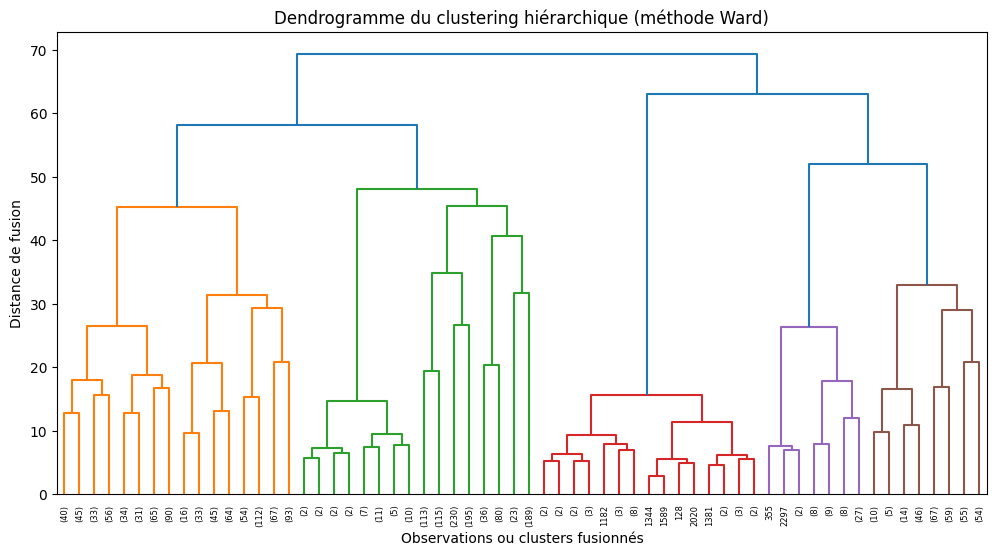

In [ ]:
# Hierarchical clustering. 
# We apply hierarchical clustering with dissimilarity measure "ward"
Z = linkage(spotify_pca, 'ward') # 'average' is the method used to compute the distance. Metric is "euclidian" by default

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Dendrogramme du clustering hiérarchique (méthode Ward)")
plt.xlabel("Observations ou clusters fusionnés")
plt.ylabel("Distance de fusion")
plt.show()

k=2, silhouette_score=0.172
k=3, silhouette_score=0.155
k=4, silhouette_score=0.058
k=5, silhouette_score=0.063
k=6, silhouette_score=0.070
k=7, silhouette_score=0.058
k=8, silhouette_score=0.057
k=9, silhouette_score=0.065
k=10, silhouette_score=0.051


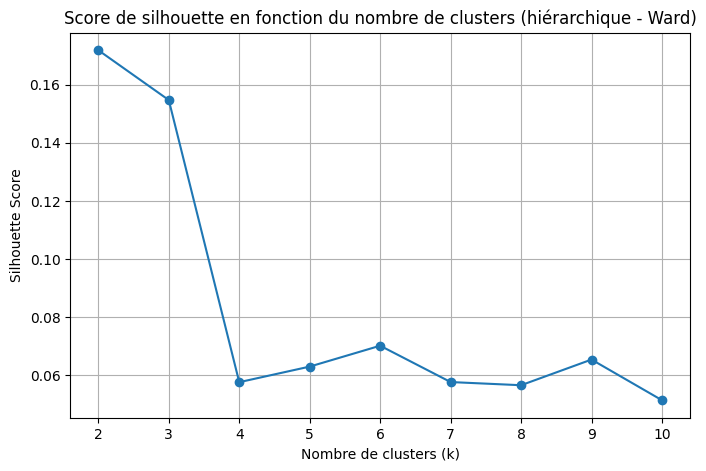

Cophenetic correlation coefficient = 0.387

 Résumé du clustering hiérarchique :
- Meilleur k = 2
- Silhouette max = 0.172
- Cophenetic corr. = 0.387


In [ ]:
silhouette_scores = []
range_k = range(2, 11)

for k in range_k:
    clusters = fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(spotify_pca, clusters)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette_score={score:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.title("Score de silhouette en fonction du nombre de clusters (hiérarchique - Ward)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = range_k[silhouette_scores.index(max(silhouette_scores))]

# Appliquer le meilleur clustering
clusters_best = fcluster(Z, best_k, criterion='maxclust')

# Évaluer la fidélité du clustering hiérarchique
c, coph_dists = cophenet(Z, pdist(spotify_pca))
print(f"Cophenetic correlation coefficient = {c:.3f}")

# Résumé final
print("\n Résumé du clustering hiérarchique :")
print(f"- Meilleur k = {best_k}")
print(f"- Silhouette max = {max(silhouette_scores):.3f}")
print(f"- Cophenetic corr. = {c:.3f}")

# Le clustering est pas fou

In [ ]:
# Cette fois-ci je ressaie mais en enlevant des variables de variance trop faible
spotify_2=numeric_df.copy()

selVarianceThreshold = VarianceThreshold(threshold=1)
spotify_2_Variance= selVarianceThreshold.fit_transform(spotify_2) 

# Masque booléen des colonnes conservées
support_mask = selVarianceThreshold.get_support()

# Colonnes conservées et supprimées
colonnes_conservees = spotify_2.columns[support_mask]
colonnes_supprimees = spotify_2.columns[~support_mask]

print("Colonnes conservées :", list(colonnes_conservees))
print("Colonnes supprimées :", list(colonnes_supprimees))

# Nouveau DataFrame filtré (en gardant les noms de colonnes)
spotify_2 = spotify_2[colonnes_conservees]


Colonnes conservées : ['year', 'track_popularity', 'artist_popularity', 'key', 'loudness', 'tempo']
Colonnes supprimées : ['danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms', 'time_signature']


<function matplotlib.pyplot.show(close=None, block=None)>

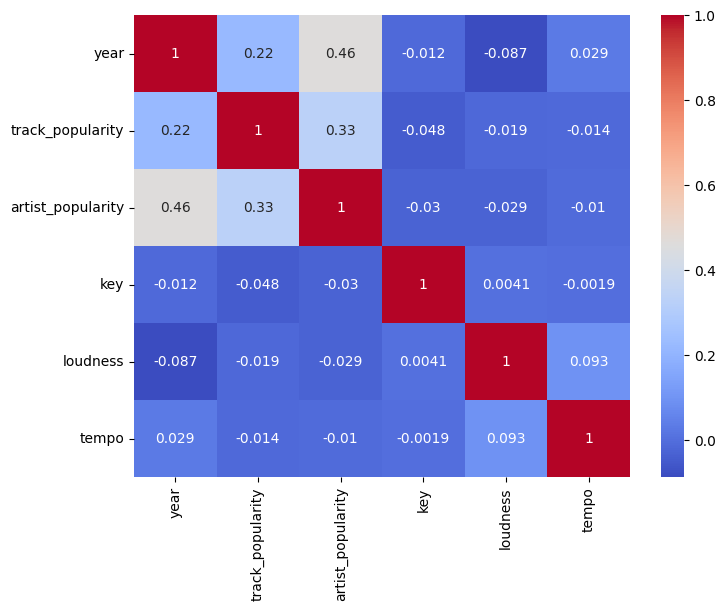

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(spotify_2.corr(), cmap="coolwarm", annot=True) # les variables ayant coefficient > 0.8 portent souvent la même info
plt.show

# bcp de problms de corrélation

In [ ]:
#Calcul du PCA again

# Etape de standardisation
scaler = StandardScaler()
data_scaled_2 = scaler.fit_transform(spotify_2)

pca=PCA()
spotify_pca_2=pca.fit_transform(data_scaled_2)

explained_variance_2 = pca.explained_variance_ratio_ # pour chaque PC, le pourcentage de variance totale qu'elle explique
cumulative_variance_2 = np.cumsum(explained_variance_2) # variance totale exprimée par les première k-composantes

print(explained_variance)
print(np.linalg.matrix_rank(data_scaled_2)) # 6 maintenant

[0.15899349 0.11022387 0.09396384 0.07082962 0.06949586 0.06741224
 0.0644593  0.06023695 0.05837434 0.05113926 0.04711899 0.04185914
 0.03926432 0.02944738 0.02241169 0.01476972]
6


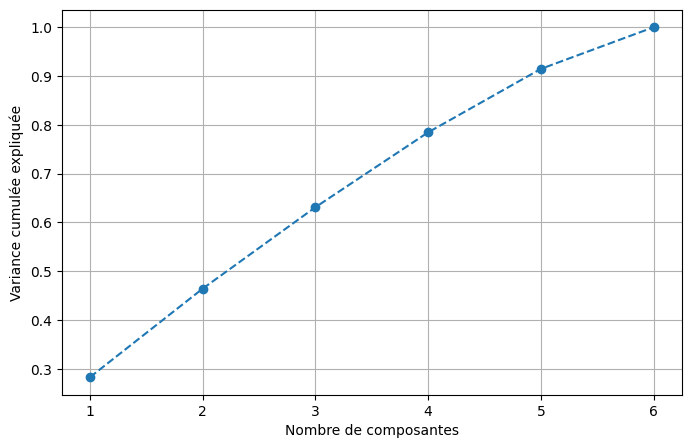

In [ ]:
# Visualisation de la variance cumulée
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance_2)+1), cumulative_variance_2, marker='o', linestyle='--')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance cumulée expliquée")
plt.grid(True)
plt.show()

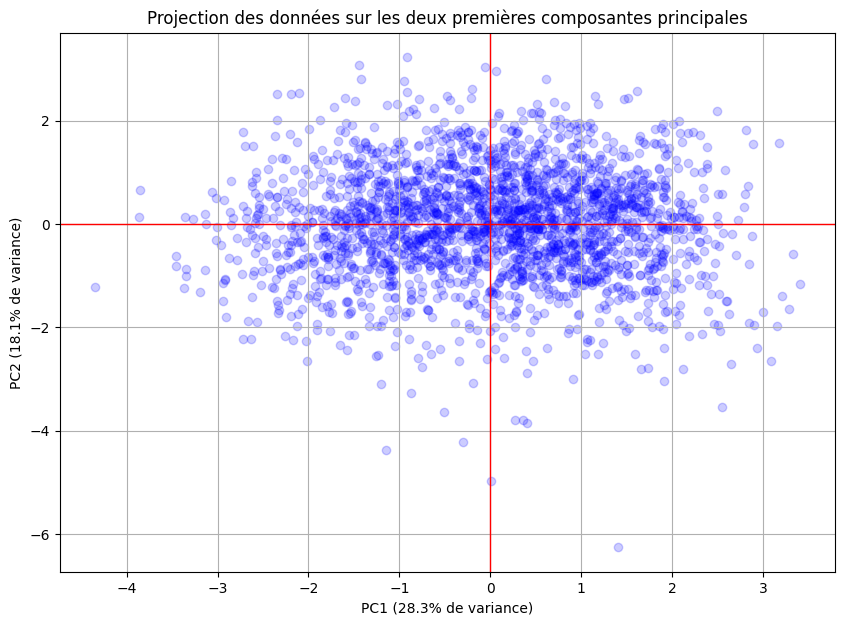

In [ ]:
# Visualisation des 2 premières PC
spotify_pca_2D = spotify_pca_2[:, :2]  # PC1 et PC2

plt.figure(figsize=(10,7))
plt.scatter(spotify_pca_2D[:,0], spotify_pca_2D[:,1], alpha=0.2, color='blue')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% de variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% de variance)")
plt.axhline(0, color='red', lw=1)
plt.axvline(0, color='red', lw=1)
plt.title("Projection des données sur les deux premières composantes principales")
plt.grid(True)
plt.show()

# On a tjrs une tâche centrale avec des outliers plutôt que des clusters

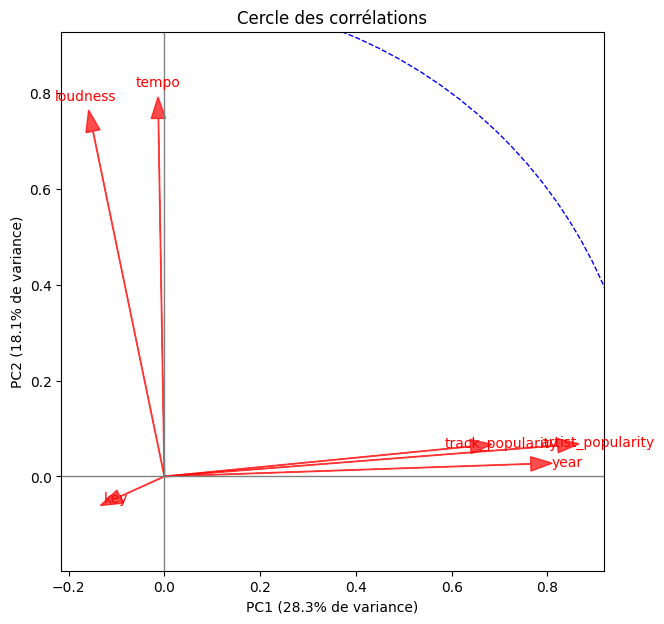

In [ ]:
loading2= pca.components_.T * np.sqrt(pca.explained_variance_)

data_scaled_df_2 = pd.DataFrame(data_scaled_2, columns=spotify_2.columns)

plt.figure(figsize=(7,7))
for i, var in enumerate(data_scaled_df_2.columns):
    plt.arrow(0, 0, loading2[i,0], loading2[i,1],
              color='r', alpha=0.7, head_width=0.03)
    plt.text(loading2[i,0]*1.1, loading2[i,1]*1.1, var, color='r', ha='center', va='center')

# Cercle unité
circle = plt.Circle((0,0), 1, color='blue', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% de variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% de variance)")
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title("Cercle des corrélations")
plt.axis('equal')
plt.show()

n_clusters = 2, silhouette_score = 0.191
n_clusters = 3, silhouette_score = 0.155
n_clusters = 4, silhouette_score = 0.152
n_clusters = 5, silhouette_score = 0.164
n_clusters = 6, silhouette_score = 0.173
n_clusters = 7, silhouette_score = 0.162
n_clusters = 8, silhouette_score = 0.156
n_clusters = 9, silhouette_score = 0.158
n_clusters = 10, silhouette_score = 0.147
n_clusters = 11, silhouette_score = 0.149
n_clusters = 12, silhouette_score = 0.148
n_clusters = 13, silhouette_score = 0.147
n_clusters = 14, silhouette_score = 0.150
n_clusters = 15, silhouette_score = 0.146
n_clusters = 16, silhouette_score = 0.141
n_clusters = 17, silhouette_score = 0.146
n_clusters = 18, silhouette_score = 0.145
n_clusters = 19, silhouette_score = 0.148


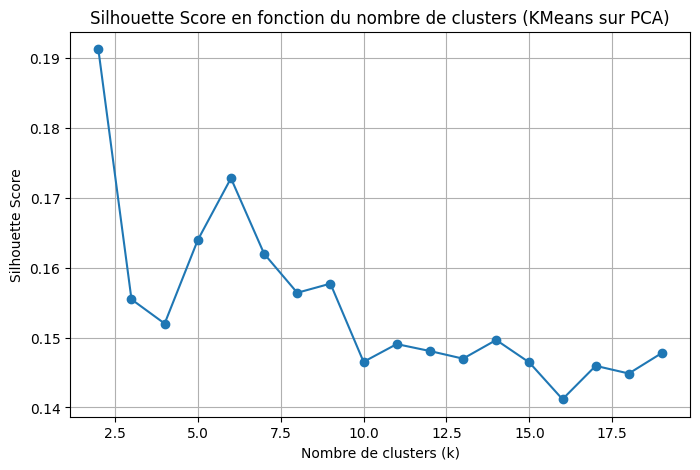

In [ ]:
#Clustering 

range_n_clusters = range(2,20)
silhouette_avgs = []

for n in range_n_clusters:
    kmeans_spotify_2 = KMeans(n_clusters=n, n_init=10).fit(spotify_pca_2) # Clustering avec n clusters
    cluster_labels_2 = kmeans_spotify_2.labels_ # Extraction des labels
    silhouette_avg = silhouette_score(spotify_pca_2, cluster_labels_2) # Silhouette score
   
    silhouette_avgs.append(silhouette_avg)
    print(f"n_clusters = {n}, silhouette_score = {silhouette_avg:.3f}")

plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, silhouette_avgs, marker='o')
plt.title("Silhouette Score en fonction du nombre de clusters (KMeans sur PCA)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Silhouette score est core une fois plutôt mauvais ( inférieur à 0.25)

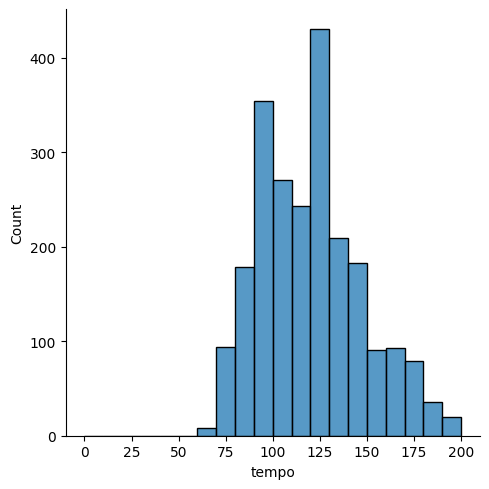

In [ ]:
sns.displot(data=numeric_df,
            x='tempo',
            kind='hist',
            bins=np.arange(0,210, 10))


In [ ]:
top_artists =data_spotify_copy.groupby('artist_name').max()['track_popularity'].to_frame().sort_values('track_popularity', ascending=False).head(10)
top_artists.head(10)

,track_popularity
artist_name,
Taylor Swift,100
David Guetta,93
Rema,92
The Weeknd,92
OneRepublic,92
Bizarrap,91
The Neighbourhood,91
Glass Animals,91
Coldplay,91
